In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from cryptocmd import CmcScraper

In [2]:
def PullCryptoData(stocks):
    for ticker in stocks:
        try:
            scraper = CmcScraper(ticker)
            headers, data = scraper.get_data()
            xrp_json_data = scraper.get_data("json")
            df = scraper.get_dataframe()
            df = df.loc[:,["Date","Close"]]
            df["Ticker"] = ticker
            if stocks.index(ticker) == 0:
                dfraw = df
            else:
                dfraw = pd.concat([dfraw, df], axis = 0, ignore_index=True)
        except:
            pass
    return(dfraw.reset_index().pivot("Date","Ticker","Close")) 

In [2]:
import json
import requests
import pandas as pd
from tqdm import tqdm
import sqlite3
import datetime

In [3]:
def get_option_name_and_settlement(coin):
    """
    :param coin: crypto-currency coin name ('BTC', 'ETH')
    :return: 2 lists:
                        1.  list of traded options for the selected coin;
                        2.  list of settlement period for the selected coin.
    """

    # requests public API
    r = requests.get("https://test.deribit.com/api/v2/public/get_instruments?currency=" + coin + "&kind=option")
    result = json.loads(r.text)

    # get option name
    name = pd.json_normalize(result['result'])['instrument_name']
    name = list(name)

    # get option settlement period
    settlement_period = pd.json_normalize(result['result'])['settlement_period']
    settlement_period = list(settlement_period)

    return name, settlement_period

In [4]:
def get_option_data(coin):
    """
    :param coin: crypto-currency coin name ('BTC', 'ETH')
    :return: pandas data frame with all option data for a given coin
    """
    # get option name and settlement
    coin_name = get_option_name_and_settlement(coin)[0]
    print(coin_name)
    settlement_period = get_option_name_and_settlement(coin)[1]

    # initialize data frame
    coin_df = []

    # initialize progress bar
    pbar = tqdm(total=len(coin_name))

    # loop to download data for each Option Name
    for i in range(len(coin_name)):
        # download option data -- requests and convert json to pandas
        r = requests.get('https://test.deribit.com/api/v2/public/get_order_book?instrument_name=' + coin_name[i])
        result = json.loads(r.text)
        df = pd.json_normalize(result['result'])

        # add settlement period
        df['settlement_period'] = settlement_period[i]

        # append data to data frame
        coin_df.append(df)

        # update progress bar
        pbar.update(1)

    # finalize data frame
    coin_df = pd.concat(coin_df)

    # remove useless columns from coin_df
    columns = ['state', 'estimated_delivery_price']
    coin_df.drop(columns, inplace=True, axis=1)
    
    # close the progress bar
    pbar.close()

    return coin_df

In [5]:
# print data and time for log
print('Date and time: ' +  datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S") + ' , format: dd/mm/yyyy hh:mm:ss')

# download data -- BTC and ETH Options
btc_data = get_option_data('BTC')
eth_data = get_option_data('ETH')

Date and time: 14/12/2021 04:43:02 , format: dd/mm/yyyy hh:mm:ss


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [04:09<00:00,  1.66it/s]


In [6]:
# export data to .csv -- append to existing
btc_data.to_csv('btc_option_data.csv', index=0, mode='a', header=False)
eth_data.to_csv('eth_option_data.csv', index=0, mode='a', header=False)

In [9]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314 entries, 0 to 0
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   underlying_price    314 non-null    float64
 1   underlying_index    314 non-null    object 
 2   timestamp           314 non-null    int64  
 3   settlement_price    288 non-null    float64
 4   open_interest       314 non-null    float64
 5   min_price           314 non-null    float64
 6   max_price           314 non-null    float64
 7   mark_price          314 non-null    float64
 8   mark_iv             314 non-null    float64
 9   last_price          286 non-null    object 
 10  interest_rate       314 non-null    float64
 11  instrument_name     314 non-null    object 
 12  index_price         314 non-null    float64
 13  change_id           314 non-null    int64  
 14  bids                314 non-null    object 
 15  bid_iv              314 non-null    float64
 16  best_bid_p

In [49]:
btc_data.loc[:,["timestamp", "last_price", "instrument_name"]]

,timestamp,last_price,instrument_name
0,1639428184678,0.311,BTC-24JUN22-55000-C
0,1639428185685,0.035,BTC-31DEC21-55000-C
0,1639428185685,0.449,BTC-24JUN22-30000-C
0,1639428186692,0.063,BTC-28JAN22-55000-C
0,1639428186692,0.2075,BTC-25MAR22-45000-P
...,...,...,...
0,1639428370983,None,BTC-24DEC21-58000-P
0,1639428370982,0.135,BTC-31DEC21-44000-C
0,1639428371988,0.556,BTC-28JAN22-70000-P
0,1639428371991,0.059,BTC-14DEC21-51000-P


In [55]:
df_btc = btc_data.loc[:,["timestamp", "last_price", "instrument_name"]].reset_index(drop=True)

In [57]:
df_btc.timestamp = df_btc.timestamp.apply(lambda x:datetime.datetime.fromtimestamp(x/1000)) 
df_btc["ticker"] = df_btc.instrument_name.apply(lambda x:x.split('-')[0])
df_btc["expiry"] = df_btc.instrument_name.apply(lambda x:x.split('-')[1])
df_btc["strike"] = df_btc.instrument_name.apply(lambda x:x.split('-')[2])
df_btc["type"] = df_btc.instrument_name.apply(lambda x:x.split('-')[3])

In [59]:
df_btc = df_btc.set_index('timestamp')

In [62]:
df_btc["expiry"].unique()

array(['24JUN22', '31DEC21', '28JAN22', '25MAR22', '30SEP22', '24DEC21',
       '15DEC21', '17DEC21', '14DEC21', '25FEB22'], dtype=object)

In [63]:
df_btc["type"].unique()

array(['C', 'P'], dtype=object)

In [64]:
df_btc["strike"].unique()

array(['55000', '30000', '45000', '50000', '48000', '25000', '60000',
       '300000', '80000', '54000', '47000', '40000', '250000', '28000',
       '150000', '70000', '49000', '65000', '52000', '51000', '46000',
       '58000', '90000', '120000', '44000', '62000', '75000', '200000',
       '35000', '100000', '56000', '24000', '42000', '68000', '53000',
       '20000', '64000', '110000', '16000', '43000', '32000', '36000'],
      dtype=object)

In [107]:
def get_hist_vol_data(coin):
    """
    :param coin: crypto-currency coin name ('BTC', 'ETH')
    :return: pandas data frame with option volatility data for a given coin
    """
    r = requests.get('https://test.deribit.com/api/v2/public/get_historical_volatility?currency=' + coin)
    result = json.loads(r.text)
    coin_df = pd.DataFrame(result['result'])
    coin_df.columns = ["timestamp", "volatility"]
    return coin_df

In [112]:
# download data -- BTC and ETH Options
btc_vol_data = get_hist_vol_data('BTC')
eth_vol_data = get_hist_vol_data('ETH')

In [113]:
btc_vol_data.timestamp = btc_vol_data.timestamp.apply(lambda x:datetime.datetime.fromtimestamp(x/1000))
eth_vol_data.timestamp = eth_vol_data.timestamp.apply(lambda x:datetime.datetime.fromtimestamp(x/1000))

In [114]:
btc_vol_data

,timestamp,volatility
0,2021-11-28 08:00:00,60.310883
1,2021-11-28 08:00:00,60.310883
2,2021-11-28 09:00:00,60.297756
3,2021-11-28 10:00:00,60.276381
4,2021-11-28 11:00:00,60.310763
...,...,...
379,2021-12-14 02:00:00,76.498461
380,2021-12-14 03:00:00,76.583735
381,2021-12-14 04:00:00,76.542442
382,2021-12-14 05:00:00,76.882714


### Run below to pull whole data

In [100]:
df = pd.read_csv('DataFiltered.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

dfret = df.pct_change().apply(lambda x: np.log(1+x)).dropna()
voldf = dfret.rolling(window = 50).std().dropna()
weightdf = 1/voldf.copy()

for row in weightdf.index:
    weightdf.loc[row] = weightdf.loc[row]/weightdf.loc[row].sum()

weekly= []
monthly = []
quaterly = []
halfyearly = []

for i in range(0,len(df.index)):
    if i%7 == 0:
        weekly.append(df.index[i])
    if i%30 == 0:
        monthly.append(df.index[i])
    if i%90 == 0:
        quaterly.append(df.index[i])
    if i%180 == 0:
        halfyearly.append(df.index[i])

In [101]:
rebalances = ["weekly", "monthly", "quaterly", "halfyearly"]
rebalancing = "halfyearly"

In [103]:
ret_port = pd.DataFrame(index = dfret.index,columns=rebalances)
ret_port["EqWt"] = dfret.iloc[:,:-1].mean(axis=1)

for rebalancing in rebalances:
    if rebalancing == "weekly":
        rebalancingdays = weekly.copy()
    elif rebalancing == "monthly":
        rebalancingdays = monthly.copy()
    elif rebalancing == "quaterly":
        rebalancingdays = quaterly.copy()
    elif rebalancing == "halfyearly":
        rebalancingdays = halfyearly.copy()

    weight_port = pd.DataFrame(index = weightdf.index,columns=weightdf.columns)
    for row in weightdf[weightdf.index.isin(rebalancingdays)].index:
        weight_port.loc[row,:] = weightdf.loc[row,:]
    weight_port.ffill(inplace = True)
    weight_port.dropna(inplace = True)

    #dfret = df.pct_change().apply(lambda x: np.log(1+x)).dropna()
    #dfret["Port_Ret"] = np.nan
    for row in weight_port.index:
        ret_port.loc[row,rebalancing] = sum(weight_port.loc[row,:] * dfret.shift(-1).loc[row,])
    #dfret.dropna(inplace=True)

    if rebalancing == "weekly":
        weight_port_1 = weight_port.copy()
    elif rebalancing == "monthly":
        weight_port_2 = weight_port.copy()
    elif rebalancing == "quaterly":
        weight_port_3 = weight_port.copy()
    elif rebalancing == "halfyearly":
        weight_port_4 = weight_port.copy()


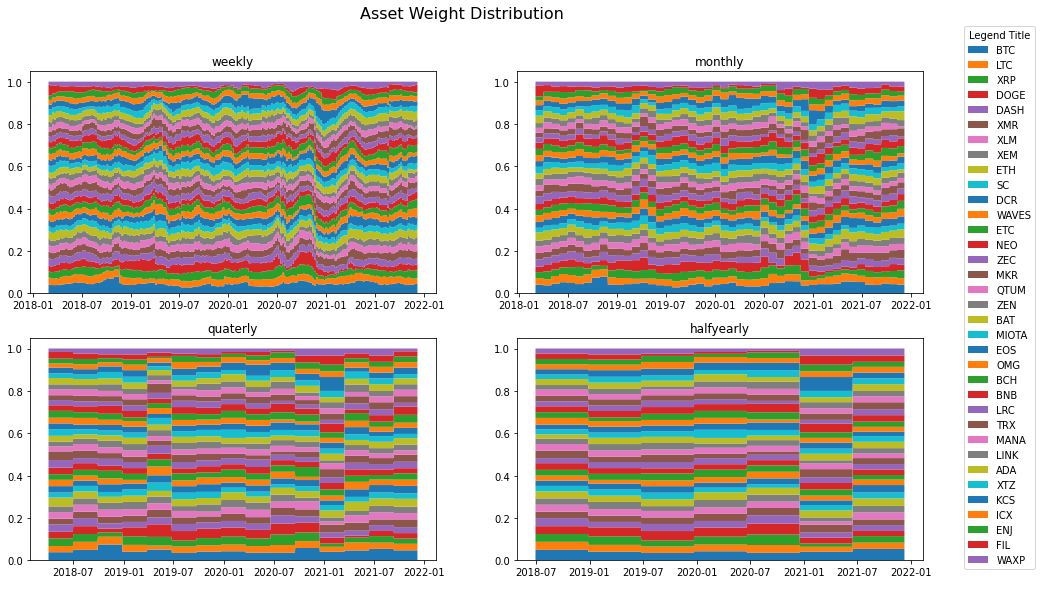

In [111]:
fig = plt.figure(figsize = (16,9))
fig.suptitle("Asset Weight Distribution", fontsize=16)

ax1 = plt.subplot(2, 2, 1)
ax1.stackplot(weight_port_1.index, *[ts for col, ts in weight_port_1.iteritems()])
ax1.title.set_text(str(rebalances[0]))

ax2 = plt.subplot(2, 2, 2)
ax2.stackplot(weight_port_2.index, *[ts for col, ts in weight_port_2.iteritems()])
ax2.title.set_text(str(rebalances[1]))

ax3 = plt.subplot(2, 2, 3)
ax3.stackplot(weight_port_3.index, *[ts for col, ts in weight_port_3.iteritems()])
ax3.title.set_text(str(rebalances[2]))

ax4 = plt.subplot(2, 2, 4)
ax4.stackplot(weight_port_4.index, *[ts for col, ts in weight_port_4.iteritems()])
ax4.title.set_text(str(rebalances[3]))

fig.legend([ax1, ax2, ax3, ax4],labels=weightdf.columns,loc="center right", title="Legend Title")

plt.show()

In [115]:
fig = plt.figure(figsize = (16,16))
fig.suptitle("Comparision of Returns", fontsize=16)

ax1 = plt.subplot(4, 1, 1)
ax1.plot(ret_port[["EqWt", rebalances[0]]].dropna().astype(float).cumsum().apply(np.exp))
ax1.title.set_text(str(rebalances[0]))

ax2 = plt.subplot(4, 1, 2)
ax2.plot(ret_port[["EqWt", rebalances[1]]].dropna().astype(float).cumsum().apply(np.exp))
ax2.title.set_text(str(rebalances[1]))

ax3 = plt.subplot(4, 1, 3)
ax3.plot(ret_port[["EqWt", rebalances[2]]].dropna().astype(float).cumsum().apply(np.exp))
ax3.title.set_text(str(rebalances[2]))

ax4 = plt.subplot(4, 1, 4)
ax4.plot(ret_port[["EqWt", rebalances[3]]].dropna().astype(float).cumsum().apply(np.exp))
ax4.title.set_text(str(rebalances[3]))

fig.legend([ax1, ax2, ax3, ax4],labels=["Equal Wgtd", "Rebalanced"],loc="center right", title="Legend")

plt.show()

NameError: name 'plt' is not defined

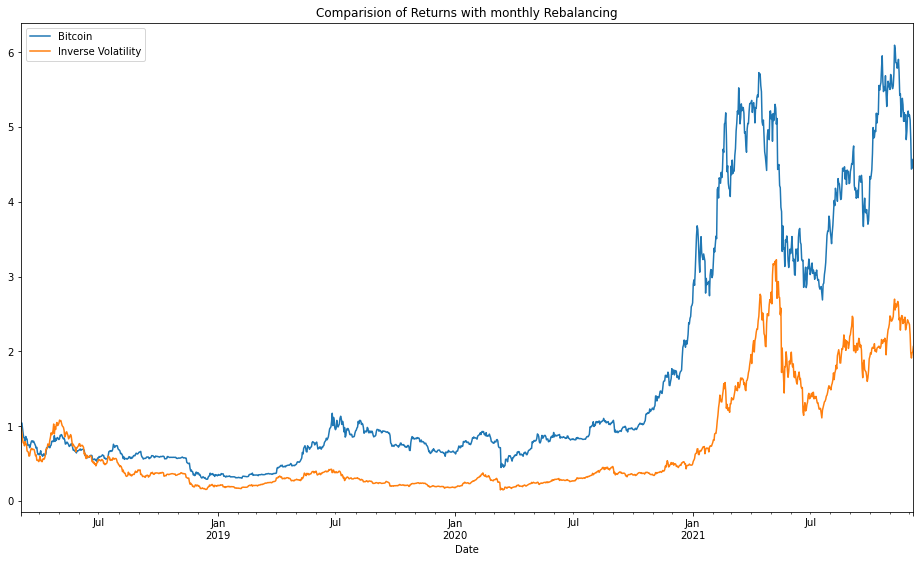

In [11]:
dfret["BTC"].cumsum().apply(np.exp).plot(label = "Bitcoin", figsize = (16,9))
plt.plot(dfret["Port_Ret"].cumsum().astype(float).apply(np.exp), label = "Inverse Volatility")
plt.title("Comparision of Returns with " + str(rebalancing) + " Rebalancing")
plt.legend()
plt.show()

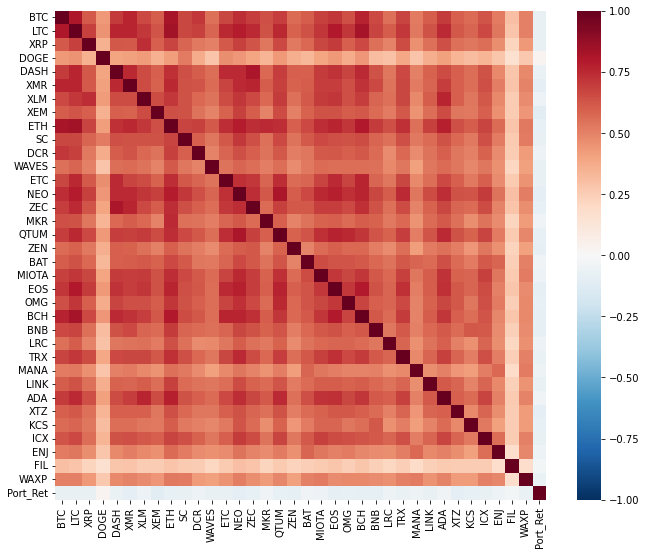

In [12]:
CorrMatrix = dfret.corr()
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(CorrMatrix, annot=False,cmap='RdBu_r', vmin=-1, vmax=1)
plt.show()